In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr

In [2]:
device = "cpu"
if(torch.cuda.is_available()):
    deivce = "gpu"

In [3]:
# training
BATCH_SIZE = 100
trainset = datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

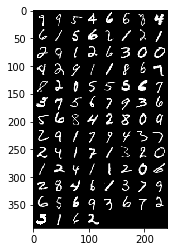

In [4]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images[0])

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
show_images(images)

In [18]:
class VAE(nn.Module):
    def __init__(self, latent_variable_dim):
        super(VAE, self).__init__()
        ########################################################
        ### MISNT D = 784, K = 784
        ### 784 - 400 - <mu : z_dim, logvar : z_dim> - 400 - 784
        ###                    /
        ###                 epsilon
        ########################################################
        
        ## Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc2m = nn.Linear(400, latent_variable_dim) # use for mean
        self.fc2s = nn.Linear(400, latent_variable_dim) # use for log variance
        
        ## Decoder
        self.fc3 = nn.Linear(latent_variable_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def reparameterize(self, log_var, mu):
        s = torch.exp(log_var)
        eps = torch.rand_like(s) - 0.5 # generate a iid standard normal same shape as s
        return eps.mul(s).add_(mu)
        
    def forward(self, input):
        x = input.view(-1, 784)
        x = torch.relu(self.fc1(x))
        log_s = self.fc2s(x)
        m = self.fc2m(x)
        z = self.reparameterize(log_s, m)
        
        x = self.decode(z)
        
        return x, m, log_s
    
    def decode(self, z):
        x = torch.relu(self.fc3(z))
        x = torch.sigmoid(self.fc4(x))
        return x

In [19]:
def loss(input_image, recon_image, mu, log_var):
    CE = F.binary_cross_entropy(recon_image, input_image.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return KLD + CE

In [20]:
vae = VAE(14)
optimizer = torch.optim.Adam(vae.parameters(), lr = 0.001)

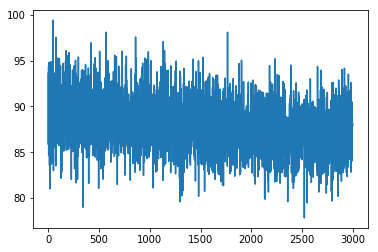

In [42]:
## train
train_loss = []
for epoch in range(5):
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        optimizer.zero_grad()
        recon_image, s, mu = vae(images)
        l = loss(images, recon_image, mu, s)
        l.backward()
        train_loss.append(l.item() / len(images))
        optimizer.step()
        
        if(i%100 == 0):
            print("Epoch no :", epoch+1, "datapoint :", i, 'curr_loss', train_loss[-1])
            clr(wait = True)
        
plt.plot(train_loss)
plt.show()

In [43]:
# test
testset = datasets.MNIST('./data/', train=False, download=False,
                   transform=transforms.ToTensor())

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

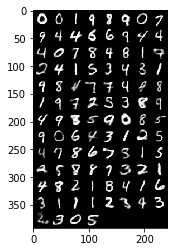

In [44]:
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        recon_image, s, mu = vae(images)
        recon_image_ = recon_image.view(BATCH_SIZE, 1, 28, 28)
        if i % 100 == 0:
            show_images(recon_image_)

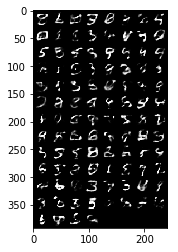

In [53]:
pz = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros((14)), covariance_matrix=torch.eye(14)*2.5)
Z = pz.sample([100])
x_recon = vae.decode(Z)
recon_image_ = x_recon.view(BATCH_SIZE, 1, 28, 28).detach()
show_images(recon_image_)